In [160]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from PIL import ImageOps, Image
import numpy as np

import pandas as pd
import json 
import tensorflow as tf
from keras import utils
import matplotlib.pyplot as plt
from sklearn import metrics


In [2]:
# my specific error/bug on gpu, dont run 

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_virtual_device_configuration(device, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2548)])

    

In [14]:
df = pd.read_csv("awe-translation.csv")
df['AWE image path'] = df['AWE image path'].apply(lambda x: "awe/"+x )

subjects = df["Subject ID"].unique()
subjects, df.columns


(array([ 11,   1,  12,   2,  13,  14,  15,  16,  17,  18,  19,  20,  21,
         22,  23,   3,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
         34,  35,   4,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,   5,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,   6,  60,  61,  62,  63,  64,  65,  66,  68,  69,  70,
         71,   7,  72,   8,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,   9,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  10,  96,  97,  98,  99, 100,  67]),
 Index(['AWE-Full image path', 'AWE image path', 'Subject ID'], dtype='object'))

In [ ]:
# add gender and ethnicity to dataframe
def gender(image_path):
    file = annotation_file(image_path)
    
    with open(file) as json_file: 
        data = json.load(json_file)
        
        if data["gender"] == "m":
            return 0
        elif data["gender"] == "f":
            return 1
        else:
            raise Exception()
            
def ethnicity(image_path):
    file = annotation_file(image_path)
    
    with open(file) as json_file: 
        data = json.load(json_file)
        
        return data["ethnicity"]
    
def annotation_file(image_path):
    image_path_split = image_path.split('/')
    json_file = "/".join(image_path_split[:-1])
    json_file += "/annotations.json"
    return json_file

df["gender"] = df['AWE image path'].apply(lambda x: gender(x) )
df["ethnicity"] = df['AWE image path'].apply(lambda x: ethnicity(x) )

# convert 99 -> 7
df["ethnicity"] = df["ethnicity"].apply(lambda x: 7 if x == 99 else x)
df.info()

In [189]:
df_train = df[df['AWE-Full image path'].str.contains("train")]
df_test = df[df['AWE-Full image path'].str.contains("test")]

In [190]:
df_train.head()

,AWE-Full image path,AWE image path,Subject ID,gender,ethnicity
250,train/0001.png,awe/100/10.png,100,0,1
251,train/0002.png,awe/010/04.png,10,0,1
252,train/0003.png,awe/011/02.png,11,0,2
253,train/0004.png,awe/011/03.png,11,0,2
254,train/0005.png,awe/011/04.png,11,0,2


In [191]:
# create X and y. we also create mirror images for better training

# from label to hitbit conversion - it always assumes y consists of integers and not strings

def from_hotbit(array):
    
    return np.argmax(array, axis=-1)

def to_hotbit(array):
    return utils.to_categorical(array)

# dataf- dataframe, analyse_column - which column will be analised, is_train for training data
def build_X_y(dataf, analyse_column , is_train=False):
    images = []
    images_mirror = []
    for path in dataf["AWE image path"]:
        img_original = image.load_img(path, target_size=(224, 224))
        # convert the image pixels to a numpy array
        img = image.img_to_array(img_original)
        # reshape data for the model
        # prepare the image for the
        img = preprocess_input(img)
        images.append(img)

        img_mirror = ImageOps.mirror(img_original)

        img = image.img_to_array(img_original)
        # reshape data for the model
        # prepare the image for the
        img = preprocess_input(img)
        images_mirror.append(img)
    
    X = np.array(images)
    X_mirror = np.array(images_mirror)
    y = np.array(to_hotbit(dataf[analyse_column]))

    if is_train:
        X = np.concatenate((X, X_mirror))
        y = np.concatenate((y, y))

    return X, y


use_on_column = "ethnicity"

X_train, y_train = build_X_y(df_train, use_on_column, is_train=True)
X_test, y_test = build_X_y(df_test, use_on_column, is_train=False)

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((1500, 8), (1500, 224, 224, 3), (250, 8), (250, 224, 224, 3))

In [192]:

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- 
predictions = Dense(y_train.shape[1], activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



In [193]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(X_train,y_train, validation_split=0.1, shuffle= True, epochs=100, callbacks=[es], batch_size=32)


Epoch 1/100
43/43 [==============================] - 7s 162ms/step - loss: 3.2293 - val_loss: 1.2270
Epoch 2/100
43/43 [==============================] - 6s 140ms/step - loss: 1.2405 - val_loss: 2.0222
Epoch 3/100
43/43 [==============================] - 6s 145ms/step - loss: 1.0081 - val_loss: 1.0625
Epoch 4/100
43/43 [==============================] - 6s 141ms/step - loss: 0.8534 - val_loss: 0.8036
Epoch 5/100
43/43 [==============================] - 6s 137ms/step - loss: 0.6751 - val_loss: 1.0990
Epoch 6/100
43/43 [==============================] - 6s 141ms/step - loss: 0.5078 - val_loss: 1.6904


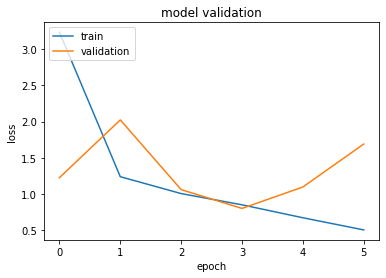

In [194]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [195]:

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.


# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
es = EarlyStopping(monitor='loss', mode='min', patience=1)

history = model.fit(X_train,y_train, validation_split=0.1, shuffle= True, epochs=100, callbacks=[es], batch_size=32)

Epoch 1/100
43/43 [==============================] - 8s 188ms/step - loss: 1.3318 - val_loss: 0.8438
Epoch 2/100
43/43 [==============================] - 7s 169ms/step - loss: 0.9022 - val_loss: 0.6712
Epoch 3/100
43/43 [==============================] - 7s 170ms/step - loss: 0.7199 - val_loss: 0.6423
Epoch 4/100
43/43 [==============================] - 8s 184ms/step - loss: 0.6321 - val_loss: 0.6486
Epoch 5/100
43/43 [==============================] - 7s 174ms/step - loss: 0.5772 - val_loss: 0.6428
Epoch 6/100
43/43 [==============================] - 7s 171ms/step - loss: 0.5330 - val_loss: 0.6275
Epoch 7/100
43/43 [==============================] - 7s 170ms/step - loss: 0.4877 - val_loss: 0.6091
Epoch 8/100
43/43 [==============================] - 7s 170ms/step - loss: 0.4595 - val_loss: 0.5808
Epoch 9/100
43/43 [==============================] - 7s 170ms/step - loss: 0.4120 - val_loss: 0.5556
Epoch 10/100
43/43 [==============================] - 7s 170ms/step - loss: 0.3885 - val_lo

In [142]:


def calculate_cmc(y_pred, y_test, num_ranks=10):

    ranks = num_ranks
    rank_scores = np.zeros(ranks)

    for el_pred, el_true in zip(y_pred, y_test):   
        for r in range(ranks):
            r_max_val_ind = np.argsort(el_pred)[-(r+1):][0]
            r_max_val = el_pred[r_max_val_ind]
            correct_ranks = ((el_pred >= r_max_val) * 1)

            yind = np.argmax(el_true, axis=-1)
            if correct_ranks[yind] == 1:
                rank_scores[r] += 1


    rank_scores = rank_scores / y_pred.shape[0]
    return rank_scores

#y_pre = np.array([[0.2,0.4,0.6,0.8]])
#y_tes = np.array([[0, 1, 0, 0]])
#calculate_cmc(y_pre, y_tes)

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

rank1 score: 0.668
rank5 score: 0.976


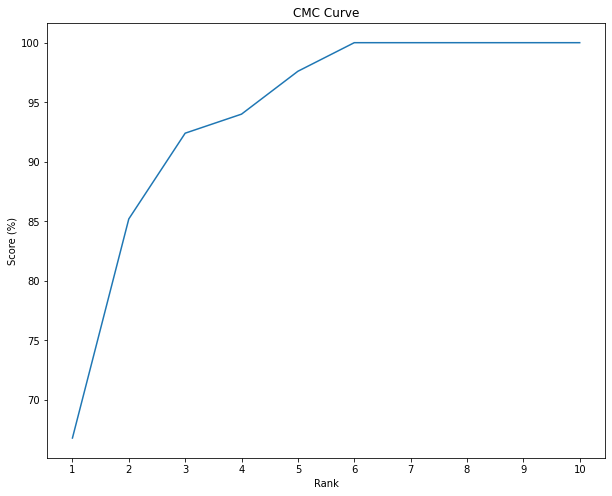

In [243]:
y_pred = model.predict(X_test)



ranks = 10
scores = calculate_cmc(y_pred, y_test, num_ranks=ranks)

plt.figure(figsize=(10,8))
plt.plot(np.arange(1,ranks+1), scores*100)
plt.title("CMC Curve")
plt.xlabel("Rank")
plt.xticks(np.arange(1,ranks+1))
plt.ylabel("Score (%)")
print("rank1 score:", scores[0])
print("rank5 score:", scores[4])



In [268]:
max_values = np.amax(y_pred, axis=1)
# get hotbit value
res = []
for i in range(y_pred.shape[0]):
    each_image_hotbit_pred = (max_values[i] == y_pred[i]) *1
    res.append(each_image_hotbit_pred)

y_pred_bi = np.array(res)

y_pred_hot = from_hotbit(y_pred_bi)
y_test_hot = from_hotbit(y_test)


print(metrics.classification_report(y_test_hot, y_pred_hot))
print(metrics.precision_recall_fscore_support(y_test_hot, y_pred_hot, average='weighted'))
print(metrics.accuracy_score(y_test_hot, y_pred_hot))

              precision    recall  f1-score   support

           1       0.71      0.92      0.80       153
           2       0.45      0.32      0.38        47
           3       0.00      0.00      0.00         3
           4       0.56      0.34      0.43        29
           5       1.00      0.14      0.25         7
           6       1.00      0.12      0.22         8
           7       0.00      0.00      0.00         3

    accuracy                           0.67       250
   macro avg       0.53      0.26      0.30       250
weighted avg       0.64      0.67      0.62       250

(0.6448228477670103, 0.668, 0.6235728132387707, None)
0.668
